In [35]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import os

In [36]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

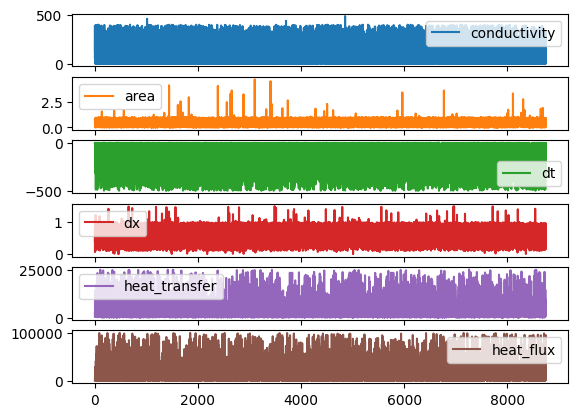

In [37]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [38]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [39]:
print(dados)

      conductivity      area          dt        dx  heat_transfer
0        63.111294  0.726220   -5.418949  0.396785     625.942602
1       390.315403  0.550835  -10.175181  0.809314    2703.103911
2       128.688361  0.412759   -2.963700  0.066487    2367.748112
3       275.121575  0.503131  -37.677718  0.372159   14013.995903
4        84.157084  0.752622  -14.939307  0.828538    1142.051134
...            ...       ...         ...       ...            ...
8746    209.907686  0.012879 -346.854045  0.762983    1228.952642
8747    297.653555  0.874757   -2.135365  0.230381    2413.369820
8748    318.011234  0.704840  -19.355605  0.471169    9207.956198
8749     91.232850  0.932163   -5.328573  0.177295    2555.983115
8750    313.064179  0.540612   -3.562181  0.227416    2651.022886

[8751 rows x 5 columns]


In [40]:
print(target)

0         861.919065
1        4907.282085
2        5736.400476
3       27853.555260
4        1517.429357
            ...     
8746    95424.636494
8747     2758.903409
8748    13063.902182
8749     2741.991095
8750     4903.742732
Name: heat_flux, Length: 8751, dtype: float64


In [41]:
target = np.array(target)
dados = np.array(dados)

In [42]:
print(dados)

[[ 6.31112943e+01  7.26219696e-01 -5.41894906e+00  3.96785386e-01
   6.25942602e+02]
 [ 3.90315403e+02  5.50835241e-01 -1.01751813e+01  8.09313575e-01
   2.70310391e+03]
 [ 1.28688361e+02  4.12758510e-01 -2.96369982e+00  6.64865841e-02
   2.36774811e+03]
 ...
 [ 3.18011234e+02  7.04839647e-01 -1.93556046e+01  4.71168539e-01
   9.20795620e+03]
 [ 9.12328501e+01  9.32163171e-01 -5.32857303e+00  1.77294852e-01
   2.55598311e+03]
 [ 3.13064179e+02  5.40612147e-01 -3.56218105e+00  2.27416353e-01
   2.65102289e+03]]


In [43]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [44]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [46]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [47]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\lucca\AppData\Local\Temp\ipykernel_3128\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [48]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "n_neurons": np.arange(10, 256),
    "learning_rate": reciprocal(3e-5, 3e-2),
    "activation": ["tanh"],
}

In [49]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=75,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/75
103/103 - 1s - loss: 0.6691 - val_loss: 0.4923 - 846ms/epoch - 8ms/step
Epoch 2/75
103/103 - 0s - loss: 0.3545 - val_loss: 0.3329 - 153ms/epoch - 1ms/step
Epoch 3/75
103/103 - 0s - loss: 0.2449 - val_loss: 0.2494 - 151ms/epoch - 1ms/step
Epoch 4/75
103/103 - 0s - loss: 0.1749 - val_loss: 0.1827 - 151ms/epoch - 1ms/step
Epoch 5/75
103/103 - 0s - loss: 0.1367 - val_loss: 0.1495 - 154ms/epoch - 1ms/step
Epoch 6/75
103/103 - 0s - loss: 0.1113 - val_loss: 0.1209 - 156ms/epoch - 2ms/step
Epoch 7/75
103/103 - 0s - loss: 0.0960 - val_loss: 0.0993 - 152ms/epoch - 1ms/step
Epoch 8/75
103/103 - 0s - loss: 0.0802 - val_loss: 0.0896 - 152ms/epoch - 1ms/step
Epoch 9/75
103/103 - 0s - loss: 0.0704 - val_loss: 0.0726 - 166ms/epoch - 2ms/step
Epoch 10/75
103/103 - 0s - loss: 0.0618 - val_loss: 0.0680 - 153ms/epoch - 1ms/step
Epoch 11/75
103/103 - 0s - loss: 0.0550 - val_loss: 0.0638 - 153ms/epoch - 1ms/step
Epoch 12/75
103/103 - 0s - loss: 0.0517 - val_loss: 0.0560 - 157ms/epoch - 2ms/step
E

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000294ECB58BE0>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['tanh'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000294E990C7C0>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10, 11, 12, 13, 14, 15,
                                                     16, 17, 18, 19, 20],
                                        'n_neurons': array([...
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])})

In [50]:
model = rnd_search_cv.best_estimator_.model

In [51]:
hist = model.history.history

In [52]:
rnd_search_cv.best_params_

{'activation': 'tanh',
 'learning_rate': 0.0016914070162460096,
 'n_hidden': 18,
 'n_neurons': 30}

In [53]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_387 (Dense)           (None, 30)                180       
                                                                 
 dense_388 (Dense)           (None, 30)                930       
                                                                 
 dense_389 (Dense)           (None, 30)                930       
                                                                 
 dense_390 (Dense)           (None, 30)                930       
                                                                 
 dense_391 (Dense)           (None, 30)                930       
                                                                 
 dense_392 (Dense)           (None, 30)                930       
                                                                 
 dense_393 (Dense)           (None, 30)              

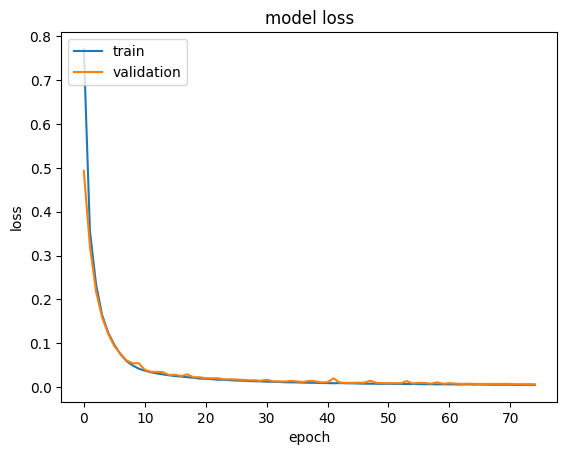

In [54]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [55]:
mse_test = model.evaluate(x_test, y_test) #mse

69/69 [==============================] - 0s 892us/step - loss: 0.0070


In [56]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

69/69 [==============================] - 0s 777us/step


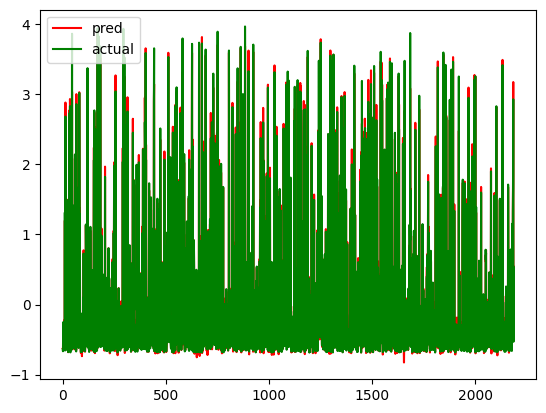

In [57]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

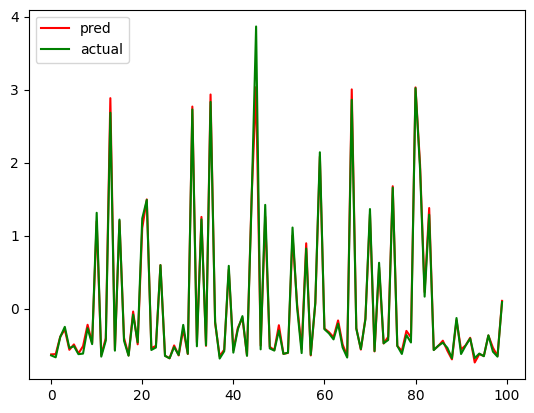

In [58]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [59]:
mean_squared_error(y_test, y_pred)

0.007025176424505082

In [60]:
#showing the predictions of the first 10 values 
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1,1))
for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", y_test_inversed[i])


pred:  [1265.5491] actual:  [976.27111299]
pred:  [1352.1038] actual:  [408.57935625]
pred:  [6474.9204] actual:  [6400.32789191]
pred:  [8603.754] actual:  [9366.05256615]
pred:  [2619.1467] actual:  [3143.54113688]
pred:  [4198.8833] actual:  [3689.4829673]
pred:  [1558.1995] actual:  [1335.51892651]
pred:  [3672.0032] actual:  [1499.86107865]
pred:  [9981.348] actual:  [8974.92157781]
pred:  [4602.821] actual:  [4286.89466876]


In [61]:
dataset_test = pd.read_csv('teste.csv')

In [62]:
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [63]:
new_mse_test = model.evaluate(dados, target)

182/182 [==============================] - 0s 810us/step - loss: 0.0063


In [64]:
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

mse test:  0.007025177124887705
mse new test:  0.006292384583503008


In [65]:
#the name of the model will include its amount of hidden layers, its amount of neurons and the amount of indexes in the dataset
#that were used to train it
amount = len(dataset)

name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) +  "_"+ str(amount) + ".h5"
model.save(name)
print("model saved")

model saved


In [66]:
#showing the first 10 predctions and the real values
y_pred = model.predict(dados)
y_pred = y_pred.flatten()

for i in range(10):
    print("pred: ", y_pred[i], "actual: ", target[i])

182/182 [==============================] - 0s 804us/step
pred:  -0.6057984 actual:  [-0.65784602]
pred:  0.11881336 actual:  [0.10432824]
pred:  -0.5823065 actual:  [-0.60580685]
pred:  3.4582944 actual:  [3.51012701]
pred:  -0.58716035 actual:  [-0.61968578]
pred:  -0.53844935 actual:  [-0.56207373]
pred:  0.4485469 actual:  [0.41210784]
pred:  -0.49091202 actual:  [-0.52443041]
pred:  2.0301378 actual:  [2.02190621]
pred:  -0.5826598 actual:  [-0.58386968]


In [67]:
#Plotting the predictions and the real values
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
target_inversed = scaler.inverse_transform(target.reshape(-1,1))

for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", target_inversed[i])

pred:  [1787.1516] actual:  [645.15002998]
pred:  [17686.207] actual:  [17368.38302212]
pred:  [2302.5989] actual:  [1786.96653537]
pred:  [90959.37] actual:  [92096.65674403]
pred:  [2196.0989] actual:  [1482.44210005]
pred:  [3264.89] actual:  [2746.53587837]
pred:  [24921.05] actual:  [24121.52374263]
pred:  [4307.9287] actual:  [3572.48616686]
pred:  [59623.496] actual:  [59442.88617788]
pred:  [2294.848] actual:  [2268.30055023]


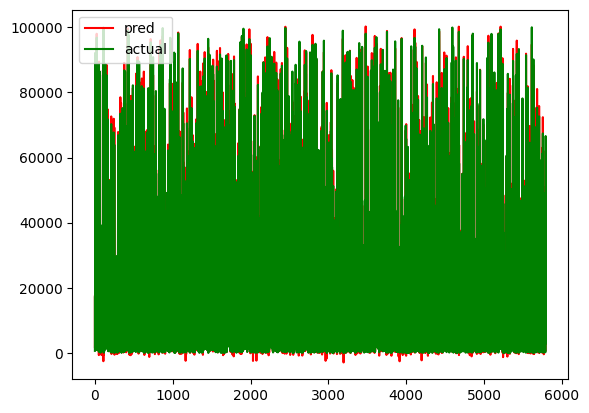

In [68]:
plt.plot(y_pred_inversed, color="red", label="pred")
plt.plot(target_inversed, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()